<a href="https://colab.research.google.com/github/jacksteel5314/FootballGamblingLines/blob/main/Sports_DataScience_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project:** NFL Oddsmakers Performance Analysis
##### **Group Members:** Dylan Paul, Thomas Colicchio, Cason Pierce, Jack Steel

#**Imports**

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()

try:
    import sklearn
    print(sklearn.__version__)
    if (sklearn.__version__ != '1.2.1' and sklearn.__version__ != '1.2.2'): #update for latest otter version
        !pip install -U --user scikit-learn
except Exception as e:
    !pip install scikit-learn

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

1.2.2


#**Read in datasets**

In [ ]:
stadiums = pd.read_csv("/content/nfl_stadiums.csv", encoding = 'unicode_escape')
teams = pd.read_csv("/content/nfl_teams.csv", encoding = 'unicode_escape')
games = pd.read_csv("/content/spreadspoke_scores.csv", encoding = "unicode_escape").dropna(subset = ["team_favorite_id", "over_under_line", "spread_favorite"])
games = games[games["over_under_line"] != " "]
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
350,1/14/1968,1967,Superbowl,True,Green Bay Packers,33,14,Oakland Raiders,GB,-13.5,43,Orange Bowl,True,60.0,12.0,74.0,NaN
538,1/12/1969,1968,Superbowl,True,Baltimore Colts,7,16,New York Jets,IND,-18.0,40,Orange Bowl,True,66.0,12.0,80.0,rain
727,1/11/1970,1969,Superbowl,True,Kansas City Chiefs,23,7,Minnesota Vikings,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,84.0,rain
916,1/17/1971,1970,Superbowl,True,Baltimore Colts,16,13,Dallas Cowboys,IND,-2.5,36,Orange Bowl,True,59.0,11.0,60.0,NaN
1105,1/16/1972,1971,Superbowl,True,Dallas Cowboys,24,3,Miami Dolphins,DAL,-6.0,34,Tulane Stadium,True,34.0,18.0,40.0,NaN


#**Data Wrangling**

In [ ]:
# Add column for total score
games["Total Score"] = games["score_home"] + games["score_away"]


games = pd.merge(games,teams[['team_name','team_id']], left_on='team_home', right_on = "team_name", how='left').drop(["team_name"], axis = 1).rename({"team_id": "home_id"}, axis='columns')
games = pd.merge(games,teams[['team_name','team_id']], left_on='team_away', right_on = "team_name", how='left').drop(["team_name"], axis = 1).rename({"team_id": "away_id"}, axis='columns')

"""
# Create mapping from team name to team ID
keys = teams["team_name"]
values = teams["team_id"]
mapping = {keys[i]: values[i] for i in range(len(keys))}


# Add home/away ID columns
games["home_id"] = [mapping[team] for team in games["team_home"]]
games["away_id"] = [mapping[team] for team in games["team_away"]]
"""

homeTeams = games["home_id"]
awayTeams = games["away_id"]


# Add column for team_id of the winner
scoreDiff = games["score_home"] - games["score_away"]
indices = scoreDiff.index
winner = [homeTeams[i] if (scoreDiff[i] >= 0) else awayTeams[i] for i in indices]
games["winner"] = winner


# Add a column for the actual spread of the game (underdog_score - favorite_score)
actualSpread = [-scoreDiff[i] if (games["team_favorite_id"][i] == games["home_id"][i]) else scoreDiff[i] for i in indices]
games["actual spread"] = actualSpread


# Add 2 columns for the differences in spread and total scores (actual - predicted)
games["actualSpread - predictedSpread"] = games["actual spread"] - games["spread_favorite"]
games["actualTotal - predictedTotal"] = [games["Total Score"][i] - float(games["over_under_line"][i]) for i in indices]

# Merge stadiums and games
games = pd.merge(games,stadiums[['stadium_name','stadium_type','stadium_weather_type','stadium_surface']], left_on='stadium',right_on='stadium_name')
games.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,home_id,away_id,winner,actual spread,actualSpread - predictedSpread,actualTotal - predictedTotal,stadium_name,stadium_type,stadium_weather_type,stadium_surface
0,1/14/1968,1967,Superbowl,True,Green Bay Packers,33,14,Oakland Raiders,GB,-13.5,...,GB,LVR,GB,-19,-5.5,4.0,Orange Bowl,outdoor,warm,NaN
1,1/12/1969,1968,Superbowl,True,Baltimore Colts,7,16,New York Jets,IND,-18.0,...,IND,NYJ,NYJ,9,27.0,-17.0,Orange Bowl,outdoor,warm,NaN
2,1/17/1971,1970,Superbowl,True,Baltimore Colts,16,13,Dallas Cowboys,IND,-2.5,...,IND,DAL,IND,-3,-0.5,-7.0,Orange Bowl,outdoor,warm,NaN
3,1/18/1976,1975,Superbowl,True,Dallas Cowboys,17,21,Pittsburgh Steelers,PIT,-7.0,...,DAL,PIT,PIT,-4,3.0,2.0,Orange Bowl,outdoor,warm,NaN
4,1/21/1979,1978,Superbowl,True,Dallas Cowboys,31,35,Pittsburgh Steelers,PIT,-3.5,...,DAL,PIT,PIT,-4,-0.5,29.0,Orange Bowl,outdoor,warm,NaN


# **Data Analysis and Hypothesis Test of Total O/U Line Performance**

Mean of this distribution: 0.6022814382186531
Standard deviation of this distribution: 13.651077090387103


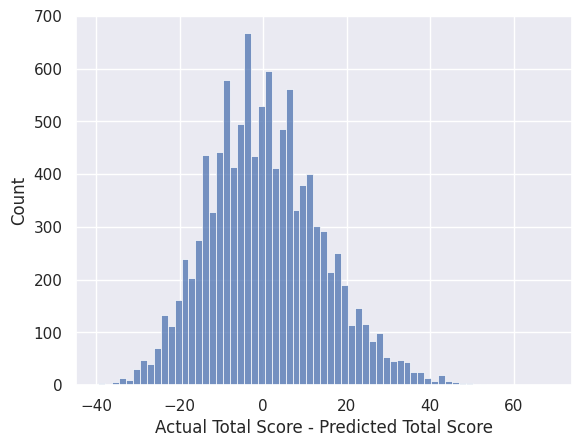

In [ ]:
# Working with the total score and O/U lines
totalDist = sns.histplot(data = games, x = "actualTotal - predictedTotal", color = "#4c72b0")
totalDist.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of this distribution: " + str(np.mean(games["actualTotal - predictedTotal"])))
print("Standard deviation of this distribution: " + str(np.std(games["actualTotal - predictedTotal"])))

Looking at this distribution, we can see that it is approximately centered around 0 with a mean of 0.6 which is to be expected. However, we notice that there appears to be a rather large amount of variance with a decent number of games where the predicted total is significantly different from the actual total score. Therefore, we will test the hypothesis that the true mean of this statistic is less than or equal 0. Let $\mu_{T}$ be the mean difference between actual total score and predicted total score.

$H_{0}: \mu_{T} \leq 0$

$H_{a}: \mu_{T} > 0$



In [ ]:
tempMean = np.mean(games["actualTotal - predictedTotal"])
tempSD = np.std(games["actualTotal - predictedTotal"])
n = len(games)

zScore = np.sqrt(n) * (tempMean - 0) / tempSD
pVal = 1 - stats.norm.cdf(zScore)
print("P-Value: " + str(pVal))

P-Value: 1.932891286915428e-06


At a significance level of $\alpha = 0.05$ and the observed p-value of $1.93 * 10^{-6}$, we reject the null hypothesis and lean in favor of the alternative hypothesis. This hypothesis test gives us evidence to believe that the mean difference between actual total score and predicted total score is greater than 0. With this insight, we note that over the course of the nearly 11,000 games in this dataset, oddsmakers have tended to underestimate the total number of points scored in NFL games. Now, we will perform a similar analysis on the statistic that measures the difference in actual and predicted spread.

#**Data Analysis and Hypothesis Test of Total Spread Line Performance**

Mean of this distribution: 0.15198941412666545
Standard deviation of this distribution: 13.337125306695679


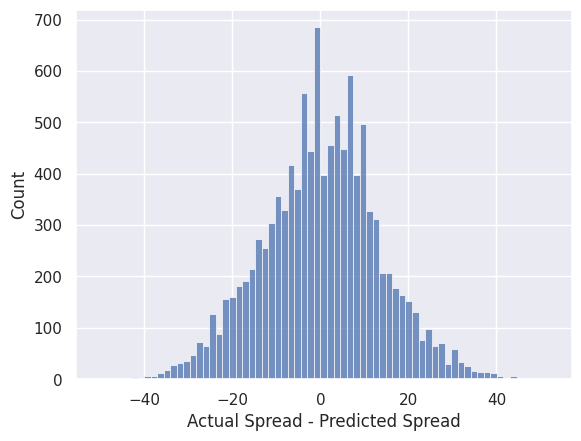

In [ ]:
spreadDist = sns.histplot(data = games, x = "actualSpread - predictedSpread", color = "#4c72b0")
spreadDist.set(xlabel='Actual Spread - Predicted Spread', ylabel='Count')
print("Mean of this distribution: " + str(np.mean(games["actualSpread - predictedSpread"])))
print("Standard deviation of this distribution: " + str(np.std(games["actualSpread - predictedSpread"])))

In a similar fashion to the difference in predicted and actual total score, this distribution is roughly centered around 0 with a mean of 0.156 and standard deviation of 13.339. We will now test a similar hypothesis to deteremine if we have evidence to believe that the true difference in actual spread and predicted spread is 0. Let $\mu_{S}$ be the mean difference in actual and predicted spread.

$H_{0}: \mu_{S} = 0$

$H_{a}: \mu_{S} \neq 0$

In [ ]:
tempMean = np.mean(games["actualSpread - predictedSpread"])
tempSD = np.std(games["actualSpread - predictedSpread"])
n = len(games)

zScore = np.sqrt(n) * (tempMean - 0) / tempSD
pVal = (1 - stats.norm.cdf(zScore)) * 2
print("P-Value: " + str(pVal))

P-Value: 0.23289485557304657


With a p-value of 0.23 and a significance level of $\alpha = 0.05$, we fail to reject the null hypothesis that the mean difference between actual and predicted spread is not 0. Note that in an unbiased environment, the mean difference between actual spread and predicted spread would be 0. With these results, we notice that oddsmakers appear to be more effective at predicting spreads than the total score. While there will inherently be games where the predicted total score or spread will be severely underestimated or overestimated, the effects of these miscalculations will be mitigated if they are equally likely to be underestimated or overestimated. While this appears to be true with the spread, there appears to be a slight bias towards underpredicting the total score. This observation leads us to believe that there may be an opportunistic gambling strategy to placing bets on the "Over" for total score. Before jumping to conclusions on the validity of this strategy, we must note that the games in this dataset date back to the 1970s. To properly assess this gambling strategy, we will analyze the predictive accuracy of gambling lines over time.

# **Graphical Representation of Spreads and O/U Lines Performance Over Time**

<ipython-input-8-4401e6871ca3>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bySeason = newGames.groupby("schedule_season").mean()[["actualSpread - predictedSpread", "actualTotal - predictedTotal"]]


[Text(0, 0, '1990'),
 Text(1, 0, '1991'),
 Text(2, 0, '1992'),
 Text(3, 0, '1993'),
 Text(4, 0, '1994'),
 Text(5, 0, '1995'),
 Text(6, 0, '1996'),
 Text(7, 0, '1997'),
 Text(8, 0, '1998'),
 Text(9, 0, '1999'),
 Text(10, 0, '2000'),
 Text(11, 0, '2001'),
 Text(12, 0, '2002'),
 Text(13, 0, '2003'),
 Text(14, 0, '2004'),
 Text(15, 0, '2005'),
 Text(16, 0, '2006'),
 Text(17, 0, '2007'),
 Text(18, 0, '2008'),
 Text(19, 0, '2009'),
 Text(20, 0, '2010'),
 Text(21, 0, '2011'),
 Text(22, 0, '2012'),
 Text(23, 0, '2013'),
 Text(24, 0, '2014'),
 Text(25, 0, '2015'),
 Text(26, 0, '2016'),
 Text(27, 0, '2017'),
 Text(28, 0, '2018'),
 Text(29, 0, '2019'),
 Text(30, 0, '2020'),
 Text(31, 0, '2021'),
 Text(32, 0, '2022')]

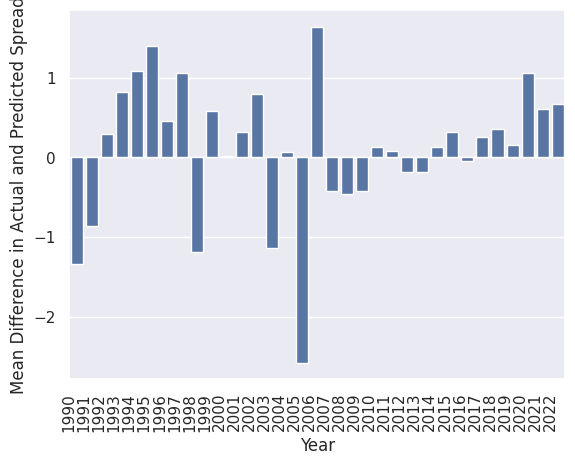

In [ ]:
newGames = games[games["schedule_season"] >= 1990]
bySeason = newGames.groupby("schedule_season").mean()[["actualSpread - predictedSpread", "actualTotal - predictedTotal"]]
years = bySeason.index
spreadDiff = bySeason["actualSpread - predictedSpread"]
totalDiff = bySeason["actualTotal - predictedTotal"]

spreadViz = sns.barplot(x = years, y = spreadDiff, color = "#4c72b0")
spreadViz.set(xlabel='Year', ylabel='Mean Difference in Actual and Predicted Spread')
spreadViz.set_xticklabels(spreadViz.get_xticklabels(), rotation=90, horizontalalignment='right')


[Text(0, 0, '1990'),
 Text(1, 0, '1991'),
 Text(2, 0, '1992'),
 Text(3, 0, '1993'),
 Text(4, 0, '1994'),
 Text(5, 0, '1995'),
 Text(6, 0, '1996'),
 Text(7, 0, '1997'),
 Text(8, 0, '1998'),
 Text(9, 0, '1999'),
 Text(10, 0, '2000'),
 Text(11, 0, '2001'),
 Text(12, 0, '2002'),
 Text(13, 0, '2003'),
 Text(14, 0, '2004'),
 Text(15, 0, '2005'),
 Text(16, 0, '2006'),
 Text(17, 0, '2007'),
 Text(18, 0, '2008'),
 Text(19, 0, '2009'),
 Text(20, 0, '2010'),
 Text(21, 0, '2011'),
 Text(22, 0, '2012'),
 Text(23, 0, '2013'),
 Text(24, 0, '2014'),
 Text(25, 0, '2015'),
 Text(26, 0, '2016'),
 Text(27, 0, '2017'),
 Text(28, 0, '2018'),
 Text(29, 0, '2019'),
 Text(30, 0, '2020'),
 Text(31, 0, '2021'),
 Text(32, 0, '2022')]

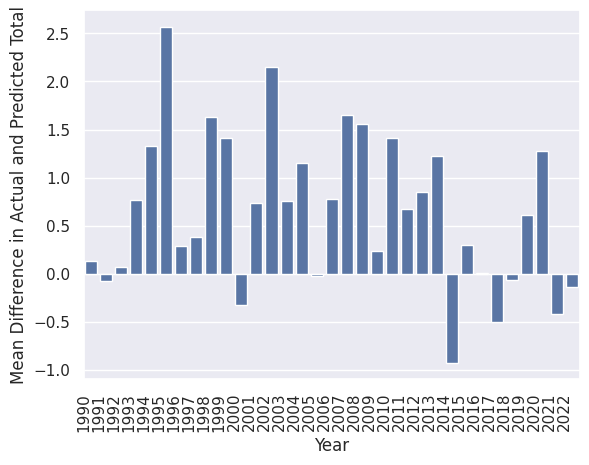

In [ ]:
totalViz = sns.barplot(x = years, y = totalDiff, color = "#4c72b0")
totalViz.set(xlabel='Year', ylabel='Mean Difference in Actual and Predicted Total')
totalViz.set_xticklabels(spreadViz.get_xticklabels(), rotation=90, horizontalalignment='right')


To get a better understanding of the accuracy of lines over time, we constructed these bar plots which allow us to see general trends in the performance of O/U and spread lines over time. To reaffirm our inclinations from the hypothesis test, we observe that the annual mean difference in actual and predicted total score is greater than 0 for the vast majority of years since 1990. Meanwhile, the trend amongst the annual spread difference data is less clear. For a majority of years since 1990 the annual mean difference in actual and predicted spread is positive, but there are some extreme outliers in the negative direction. To develop a firm statistical understanding of these qualitative observations, we will perform more testing to analyze the accuracy of these lines over time.

# **Data Analysis and Hypothesis Test of O/U Line Performance By Playing Conditions**

## Indoor vs Outdoor

Mean of outdoor O/U distribution: 0.4811655405405405
Standard deviation of outdoor O/U distribution: 13.709507197174949
Mean of indoor O/U distribution: 1.0303212851405623
Standard deviation of indoor O/U distribution: 13.562854359266394


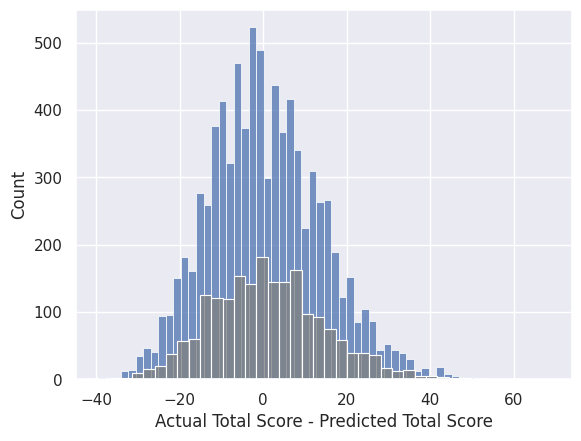

In [ ]:
# Filter the 'games' DataFrame based on stadium type and assign it to new variables
outdoor = games[games['stadium_type'] == 'outdoor']
indoor = games[games['stadium_type'] == 'indoor']

# Plotting O/U Line Performance by Stadium Type
totalDist = sns.histplot(data = outdoor, x = "actualTotal - predictedTotal", color = "#4c72b0")
totalDist.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of outdoor O/U distribution: " + str(np.mean(outdoor["actualTotal - predictedTotal"])))
print("Standard deviation of outdoor O/U distribution: " + str(np.std(outdoor["actualTotal - predictedTotal"])))

totalDist2 = sns.histplot(data = indoor, x = "actualTotal - predictedTotal", color = "#808080")
totalDist2.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of indoor O/U distribution: " + str(np.mean(indoor["actualTotal - predictedTotal"])))
print("Standard deviation of indoor O/U distribution: " + str(np.std(indoor["actualTotal - predictedTotal"])))

Above, we separate games played at outdoor stadiums and games played at indoor stadiums and plot the distributions of the difference between the actual total and predicted total. The outdoor distribution is plotted in blue while the indoor distribution is plotted in gray. As shown, many more games have been played outdoors. Looking at these distributions, we can see that while the outdoor distribution has a mean of roughly 0.5,
the indoor distribution has a mean of approximately 1. That said, both distributions appear to be centered around 0,
which suggests that the indoor distribution has a fatter right-hand tail that is pushing its mean upwards.

A two-sided hypothesis test would determine whether oddsmakers accuracy differs between indoor and outdoor games,
however, we believe a more interesting test is a one-sided hypothesis test to determine whether oddsmakers under-estimate outdoor totals relative to indoor totals. The intuitive basis of this hypothesis is that all else equal offsenses will perform better in indoor games without the impact of the weather, and so, we excpect to see more "outlier" games with totals significantly above their predicted total in indoor games. Further, the nature of a one-sided test can lead to results that have implications for a potential gambling strategy. If we reject this null hypothesis, one could reason that over a large enough sample betting the "over" on indoor games will outperform betting the "over" on outdoor games. Let $\mu_{TO}$ adn $\mu_{TI}$ be the mean difference between
actual total score and predicted total score for indoor and outdoor games respectively.

$H_{0}: \mu_{TO} \geq \mu_{TI}$

$H_{a}: \mu_{TO} < \mu_{TI}$


In [ ]:
t_stat, p_val = stats.ttest_ind(outdoor["actualTotal - predictedTotal"], indoor["actualTotal - predictedTotal"],alternative='less')

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -1.6084281847657138
p-value: 0.05388607343764481


At a significance level of $\alpha = 0.05$ and the observed p-value of $0.054$, we fail to reject the null hypothesis.
Although this p-value is very close to the 0.05 signifigance level, we cannot conclude that the difference between
the actual and predicted total is greater for indoor games than outdoor games.

## Grass vs Turf

Next, we conduct an analagous hypothesis test
to see whether or not oddsmakers underestimate the total scores for games played on turf. The rationale here is that
all else equal offenses perform better on turf relative to grass.

Mean of grass O/U distribution: 0.3418256459792321
Standard deviation of grass O/U distribution: 13.452501213198875
Mean of turf O/U distribution: 0.841978287092883
Standard deviation of turf O/U distribution: 13.746438621532631


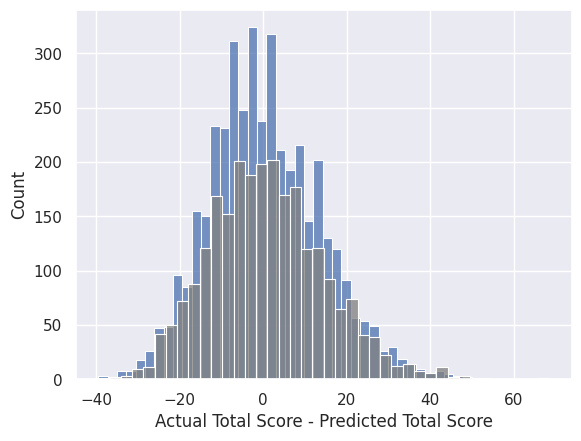

In [ ]:
# Filter the 'games' DataFrame based on surface type and assign it to new variables
grass = games[games['stadium_surface'] == 'Grass']
turf = games[(games['stadium_surface'] == 'FieldTurf') | (games['stadium_surface'] == "Hellas Matrix Turf")]

# Plotting O/U Line Performance by Surface Type
totalDist = sns.histplot(data = grass, x = "actualTotal - predictedTotal", color = "#4c72b0")
totalDist.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of grass O/U distribution: " + str(np.mean(grass["actualTotal - predictedTotal"])))
print("Standard deviation of grass O/U distribution: " + str(np.std(grass["actualTotal - predictedTotal"])))

totalDist2 = sns.histplot(data = turf, x = "actualTotal - predictedTotal", color = "#808080")
totalDist2.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of turf O/U distribution: " + str(np.mean(turf["actualTotal - predictedTotal"])))
print("Standard deviation of turf O/U distribution: " + str(np.std(turf["actualTotal - predictedTotal"])))



Once again, while both distributions are centered near 0, however the turf distribution, displayed in gray, has a longer right-hand side tail and a larger mean. For this one-sided hypothesis test, let $\mu_{TG}$ adn $\mu_{TT}$ be the mean difference between actual total score and predicted total score for grass and turf games respectively.

$H_{0}: \mu_{TG} \geq \mu_{TT}$

$H_{a}: \mu_{TG} < \mu_{TT}$

In [ ]:
t_stat, p_val = stats.ttest_ind(grass["actualTotal - predictedTotal"], turf["actualTotal - predictedTotal"],alternative='less')

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -1.4533265506619222
p-value: 0.0730902332475748


We also fail to reject this null hypotheiss at the 0.05 signifigance level. Thus, we cannot say that oddsmakers
underestimate the total score for turf games relative to grass games.

## High Wind vs Low Wind

Next, we conduct a similar analysis with wind
speed where we generate a varialbe called wind_type that tags games based on whether or not the wind speed that day was above or below the median wind speed for all games.

Mean of low wind O/U distribution: 1.0510247901620144
Standard deviation of low wind O/U distribution: 13.631184050906224
Mean of high wind O/U distribution: 0.25746892194823723
Standard deviation of high wind O/U distribution: 13.74113845476481


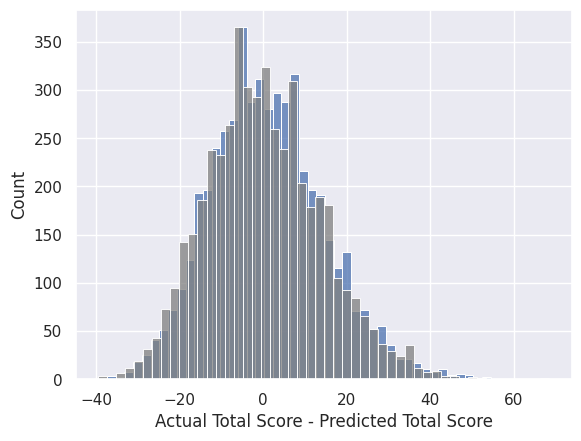

In [ ]:
games['wind_type'] = pd.qcut(games['weather_wind_mph'], q=2, labels=['low', 'high'],duplicates="drop")


wind_low = games[games['wind_type'] == 'low']
wind_high = games[games['wind_type'] == 'high']

# Plotting O/U Line Performance by Wind Speed
totalDist = sns.histplot(data = wind_low, x = "actualTotal - predictedTotal", color = "#4c72b0")
totalDist.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of low wind O/U distribution: " + str(np.mean(wind_low["actualTotal - predictedTotal"])))
print("Standard deviation of low wind O/U distribution: " + str(np.std(wind_low["actualTotal - predictedTotal"])))

totalDist2 = sns.histplot(data = wind_high, x = "actualTotal - predictedTotal", color = "#808080")
totalDist2.set(xlabel='Actual Total Score - Predicted Total Score', ylabel='Count')
print("Mean of high wind O/U distribution: " + str(np.mean(wind_high["actualTotal - predictedTotal"])))
print("Standard deviation of high wind O/U distribution: " + str(np.std(wind_high["actualTotal - predictedTotal"])))

Here, we see that the mean of the low wind distribution (blue) is over four times larger than the mean for the
high wind distribution (gray). Given these raw means, we might suspect that oddsmakers are better at predicting total
scores for high wind games. In a different sense, we might expect more outlier games in which the total score well
exceeds the predicted total in low wind conditions. Hence, we test whether or not oddsmakers underestimate low wind totals
relative to high wind totals with this one-sided hypothesis test. Let $\mu_{TL}$ and $\mu_{TH}$ be the mean
difference between actual total score and predicted total score for low wind and high wind games respectively.

$H_{0}: \mu_{TL} \leq \mu_{TH}$

$H_{a}: \mu_{TL} > \mu_{TH}$

In [ ]:
t_stat, p_val = stats.ttest_ind(wind_low["actualTotal - predictedTotal"], wind_high["actualTotal - predictedTotal"],alternative="greater")

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: 2.9027281184909532
p-value: 0.0018536686451014301


We are able to reject the null hypothesis that the difference between the actual and predicted totals for low wind
games are less than or equal to that for high wind games at the $\alpha = 0.05$ with the observed p-value of $0.0018$.
This tells us that while some may be tempted by lower O/U lines offered for high wind games, it is best in the long
run to stay away from betting the "over" on these games and a better strategy relatively speaking to bet the over on
low wind games.

# **Data Analysis and Hypothesis Test of Home/Away Favorites Spreads**

Mean of home favorite distribution: -2.175438596491228
Standard deviation of home favorite distribution: 13.40445984426355
Mean of away favorite distribution: 3.331785791405744
Standard deviation of away favorite distribution: 13.61024279528315


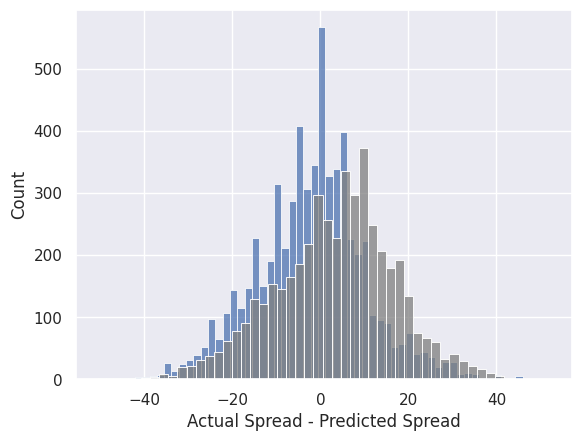

In [ ]:
games_adj= games[['actualSpread - predictedSpread','actual spread','spread_favorite','home_id','away_id','team_favorite_id','winner']].dropna()
games_adj['home_favorite'] = (games_adj['home_id']==games_adj['winner'])

home_fav = games_adj[games_adj['home_favorite']]
away_fav = games_adj[games_adj['home_favorite']==False]

#Plotting Spread Line Performance by whether the Home Team was Favorite
totalDist = sns.histplot(data = home_fav, x = "actualSpread - predictedSpread", color = "#4c72b0")
totalDist.set(xlabel='Actual Spread - Predicted Spread', ylabel='Count')
print("Mean of home favorite distribution: " + str(np.mean(home_fav["actualSpread - predictedSpread"])))
print("Standard deviation of home favorite distribution: " + str(np.std(wind_low["actualSpread - predictedSpread"])))

totalDist2 = sns.histplot(data = away_fav, x = "actualSpread - predictedSpread", color = "#808080")
totalDist2.set(xlabel='Actual Spread - Predicted Spread', ylabel='Count')
print("Mean of away favorite distribution: " + str(np.mean(away_fav["actualSpread - predictedSpread"])))
print("Standard deviation of away favorite distribution: " + str(np.std(away_fav["actualSpread - predictedSpread"])))

Below, we create a mask that indicates whether the home team was the team that was favorite. Then, we plot the
distributions of the differences between the actual spread and predicted spread of the games that the home team
was favorite in blue and those where the away team was favorite in gray. Notably, while the mean difference for games
where the home team was favorite was approximately -2, the mean difference for games where away teams were favorite was
roughly 3. Thus, in this dataset home favorites on average under perform the spread by 2 points while away favorites on average overperform the spread by 3 points. One can observe the home favorite distribution has a fatter left-hand
tail while the away favorite distribution has a fatter right-hand side tail. Next, we conduct a two-sided t-test to determine whether or not there is a true difference between the difference in actual spread and predicted spreads for games where the home versus the away team are favorite. Let $\mu_{SH}$ and $\mu_{SA}$ be the mean difference between actual spread and predicted spread for games in which the home and away team are favorite respectively.

$H_{0}: \mu_{SH} = \mu_{SA}$

$H_{a}: \mu_{SH}  != \mu_{SA}$


In [ ]:
t_stat, p_val = stats.ttest_ind(home_fav["actualSpread - predictedSpread"], away_fav["actualSpread - predictedSpread"])

print("t-statistic:", t_stat)
print("p-value:", p_val)

t-statistic: -21.80868175977445
p-value: 2.959922599494843e-103


Given the p-value of essentially 0, we can reject the null hypothesis. This is very interesting because it shows that
oddsmakers accuracy does change depending on whether the favorite is the home team or away team. Hence, we conduct two
one-sided hypothesis tests to further explore this difference. We first test if for games in which the home team is favorite the difference in actual and predicted spreads is less than 0, and for games
in which the away team is favorite we test if this difference is greater than 0. For the first test on home favorite games our hypotheses are as such:
    
$H_{0}: \mu_{SH} >= 0$

$H_{a}: \mu_{SH} < 0$

In [ ]:
tempMean = np.mean(home_fav["actualSpread - predictedSpread"])
tempSD = np.std(home_fav["actualSpread - predictedSpread"])
n = len(home_fav)

zScore = np.sqrt(n) * (tempMean - 0) / tempSD
pVal = stats.norm.cdf(zScore)
print("P-Value: {:.5f}".format(pVal/2))

P-Value: 0.00000


Given this test, we are able to reject the null hypothesis the α=.05 signifigance level. This suggests that home
favorites tend to underperform oddsmakers expectations. We test the opposite of this hypothesis for away favorites as such:
    
$H_{0}: \mu_{SA} <= 0$

$H_{a}: \mu_{SA} > 0$

In [ ]:
tempMean = np.mean(away_fav["actualSpread - predictedSpread"])
tempSD = np.std(away_fav["actualSpread - predictedSpread"])
n = len(away_fav)

zScore = np.sqrt(n) * (tempMean - 0) / tempSD
pVal = 1 - stats.norm.cdf(zScore)
print("P-Value: {:.5f}".format(pVal/2))

P-Value: 0.00000


Once again, we can reject the null hypothesis at the α=.05 signifigance level. This suggests that away favorites
overperform oddsmakers expectations. Together, this analysis suggests that oddsmakers overestimate the value of home
field advantage, and all else equal a gambler with a strategy to bet favorites on the spread is better off betting
away favorites rather than home favorites in the long run.